In [43]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
# Standard imports
import pandas as pd
import numpy as np
import re
import pickle
import string

# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt

# NLP library
from nltk.tokenize import word_tokenize


In [2]:
from numpy.random import seed
seed(42)

In [3]:
lines= pd.read_table('spa.txt', names=['eng', 'spa'])

In [4]:
lines.head()

,eng,spa
Go.,Ve.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Go.,Vete.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Go.,Vaya.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Go.,Váyase.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Hi.,Hola.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [5]:
lines.reset_index(inplace=True)
lines.columns=['eng', 'spa', 'misc']
lines.drop(columns='misc', inplace=True)

In [6]:
# Lowercase all characters
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.spa=lines.spa.apply(lambda x: x.lower())

# Remove quotes
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x))
lines.spa=lines.spa.apply(lambda x: re.sub("¿", '', x))
lines.spa=lines.spa.apply(lambda x: re.sub("'", '', x))
exclude = set(string.punctuation) # Set of all special characters

# Remove all the special characters
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.spa=lines.spa.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', string.digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.spa=lines.spa.apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.spa=lines.spa.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.spa=lines.spa.apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
#lines.mar = lines.mar.apply(lambda x : 'START_ '+ x + ' _END')

In [7]:
lines.eng

0                                                        go
1                                                        go
2                                                        go
3                                                        go
4                                                        hi
                                ...                        
128079    there are four main causes of alcoholrelated d...
128080    there are mothers and fathers who will lie awa...
128081    a carbon footprint is the amount of carbon dio...
128082    since there are usually multiple websites on a...
128083    if you want to sound like a native speaker you...
Name: eng, Length: 128084, dtype: object

In [8]:
# Defining the data
df = lines[['eng', 'spa']]

# Calculating the length of each line of dialogue
df['eng_len'] = df['eng'].apply(lambda x: len(x))
df['spa_len'] = df['spa'].apply(lambda x: len(x))

In [9]:
# Saving dataframe with dialogue length less than 50 characters
df = df[df['eng_len']< 50]
df = df[df['eng_len']> 15]
df = df[df['spa_len']> 15]
df = df[df['spa_len']< 50]

data = df.values.tolist()

# Examining the first 5 rows
data[:8]

[['a bird has wings', 'los pájaros tienen alas', 16, 23],
 ['a bird has wings', 'un pájaro tiene alas', 16, 20],
 ['a cab is waiting', 'hay un taxi esperando', 16, 21],
 ['a deal is a deal', 'un trato es un trato', 16, 20],
 ['a dog is barking', 'un perro está ladrando', 16, 22],
 ['a fox came along', 'un zorro se acercó', 16, 18],
 ['a girl phoned me', 'una chica me llamó por teléfono', 16, 31],
 ['a lion is strong', 'el león es fuerte', 16, 17]]

In [10]:
len(data)

97345

In [11]:
#Write to csv so it can be used for continuous training later
df.to_csv('./data/EngSpa.csv')

In [12]:
# Building empty lists to hold sentences
input_docs = []
target_docs = []
# Building empty vocabulary sets
input_tokens = set()
target_tokens = set()

# Setting the amount of data points to use
n = 18000

for line in data[:n]:
    # Defining an input document and a target document
    input_doc, target_doc = line[0], line[1]
    
    # Appending each input sentence to input_docs
    input_docs.append(input_doc)
    
    # Formatting target documents
    # Splitting words from punctuation  
    target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
    # Adding <START> and <END> tags
    target_doc = '<START> ' + target_doc + ' <END>'
    # Appending each formated target to target documents
    target_docs.append(target_doc)
  
    # Splitting each sentence into words and adding to vocabulary
    for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
        if token not in input_tokens:
            input_tokens.add(token)
    
    for token in target_doc.split():
        if token not in target_tokens:
            target_tokens.add(token)

In [13]:
print(input_docs[0])
print(target_docs[0])

a bird has wings
<START> los pájaros tienen alas <END>


In [14]:
# Creating a sorted list of all input tokens and target tokens
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))

# Saving the length of vocabulary sets as variables. Encoder and Decoder
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

# Finding the maximum length of an input sentence and target sentence
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

In [15]:
print(f'Number of Encoder Tokens: {num_encoder_tokens}')
print(f'Number of Decoder Tokens: {num_decoder_tokens}')
print(f'Maximum Encoder Sequence Length: {max_encoder_seq_length}')
print(f'Maximum Decoder Sequence Length: {max_decoder_seq_length}')

Number of Encoder Tokens: 4428
Number of Decoder Tokens: 7675
Maximum Encoder Sequence Length: 7
Maximum Decoder Sequence Length: 16


In [16]:
# Creating four dictionaries
input_features_dict = dict(
    [(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

# Creating the reverse 
reverse_input_features_dict = dict(
    (i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict(
    (i, token) for token, i in target_features_dict.items())

In [17]:
import pickle

with open('./data/rtfd.p', 'wb') as fp:
    pickle.dump(reverse_target_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/tfd.p', 'wb') as fp:
    pickle.dump(target_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/rifd.p', 'wb') as fp:
    pickle.dump(reverse_input_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/ifd.p', 'wb') as fp:
    pickle.dump(input_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
# Python 3
first2pairs = {k: reverse_input_features_dict[k] for k in list(reverse_input_features_dict)[:2]}
first2pairs

{0: 'a', 1: 'aback'}

In [19]:
# Python 3
first2pairs = {k: input_features_dict[k] for k in list(input_features_dict)[:2]}
first2pairs

{'a': 0, 'aback': 1}

In [20]:
# Python 3
first2pairs = {k: target_features_dict[k] for k in list(target_features_dict)[2:8]}
first2pairs

{'a': 2,
 'abajo': 3,
 'abandona': 4,
 'abandonado': 5,
 'abandonados': 6,
 'abandonamos': 7}

In [21]:
# Creating empty matricies for input data

encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [22]:
print(f'Encoder Input Data Shape: {encoder_input_data.shape}')
print(f'Decoder Input Data Shape: {decoder_input_data.shape}')
print(f'Decoder Target Data Shape: {decoder_target_data.shape}')

Encoder Input Data Shape: (18000, 7, 4428)
Decoder Input Data Shape: (18000, 16, 7675)
Decoder Target Data Shape: (18000, 16, 7675)


In [23]:
# This block of code sets up our data for input to the neural net.

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):

    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        # Assigning 1.0 for the current line, timestep, & word in encoder_input_data:
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.0
        # Potential Conditional Statement

    for timestep, token in enumerate(target_doc.split()):
        # Assigning 1.0 for same in decoder_input_data
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.0
        if timestep > 0:
            
            # Setting the decoder target data for 1 previous timestep
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.0

In [24]:
np.argmax(encoder_input_data[1])

0

In [25]:
reverse_input_features_dict[0]

'a'

In [26]:
print(num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length)

4428 7675 7 16


In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Masking
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.backend import manual_variable_initialization

manual_variable_initialization(True)
import os

In [28]:
tf.random.set_seed(42)

In [29]:
#Defining the model structure
latent_dim = 256 ### CHANGE THIS
batch_size = 128
epochs = 50

# Encoder training setup
encoder_inputs = Input(shape=(None, num_encoder_tokens))

encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) 
encoder_states = [state_h, state_c]

# Decoder training setup:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,_ ,_ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [30]:
epochs = 25
batch_size = 128

#callback = EarlyStopping(monitor='val_accuracy', patience=4)

training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')

model_checkpoint= ModelCheckpoint('endspan{epoch:02d}.h5',period=5,save_weights_only=False)

history = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    callbacks=[model_checkpoint],         
                    validation_split = 0.2)
                    #callbacks = callback)


Epoch 1/25
113/113 [==============================] - 192s 2s/step - loss: 2.0757 - accuracy: 0.7124 - val_loss: 2.0557 - val_accuracy: 0.7288
Epoch 2/25
113/113 [==============================] - 180s 2s/step - loss: 1.8462 - accuracy: 0.7533 - val_loss: 2.0620 - val_accuracy: 0.7303
Epoch 3/25
113/113 [==============================] - 178s 2s/step - loss: 1.8205 - accuracy: 0.7534 - val_loss: 2.0738 - val_accuracy: 0.7289
Epoch 4/25
113/113 [==============================] - 176s 2s/step - loss: 1.8027 - accuracy: 0.7542 - val_loss: 2.0685 - val_accuracy: 0.7334
Epoch 5/25
113/113 [==============================] - 180s 2s/step - loss: 1.7823 - accuracy: 0.7579 - val_loss: 2.0392 - val_accuracy: 0.7414
Epoch 6/25
113/113 [==============================] - 186s 2s/step - loss: 1.7493 - accuracy: 0.7643 - val_loss: 2.0065 - val_accuracy: 0.7446
Epoch 7/25
113/113 [==============================] - 179s 2s/step - loss: 1.7116 - accuracy: 0.7684 - val_loss: 1.9796 - val_accuracy: 0.7482

In [31]:
epochs = 15
history2 = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    callbacks=[model_checkpoint],         
                    validation_split = 0.2)
                    #callbacks = callback)


Epoch 1/15
113/113 [==============================] - 195s 2s/step - loss: 1.2402 - accuracy: 0.8281 - val_loss: 1.7338 - val_accuracy: 0.7864
Epoch 2/15
113/113 [==============================] - 180s 2s/step - loss: 1.2220 - accuracy: 0.8303 - val_loss: 1.7257 - val_accuracy: 0.7868
Epoch 3/15
113/113 [==============================] - 177s 2s/step - loss: 1.2044 - accuracy: 0.8327 - val_loss: 1.7226 - val_accuracy: 0.7887
Epoch 4/15
113/113 [==============================] - 182s 2s/step - loss: 1.1861 - accuracy: 0.8351 - val_loss: 1.7127 - val_accuracy: 0.7883
Epoch 5/15
113/113 [==============================] - 180s 2s/step - loss: 1.1694 - accuracy: 0.8371 - val_loss: 1.7044 - val_accuracy: 0.7906
Epoch 6/15
113/113 [==============================] - 177s 2s/step - loss: 1.1534 - accuracy: 0.8394 - val_loss: 1.7088 - val_accuracy: 0.7901
Epoch 7/15
113/113 [==============================] - 181s 2s/step - loss: 1.1380 - accuracy: 0.8416 - val_loss: 1.6924 - val_accuracy: 0.7921

In [32]:
#Saving the model so we can use later
#tf.saved_model.save(training_model, './models/')
training_model.save('training_model_v2.h5')
training_model.save_weights('tr_weights.h5')

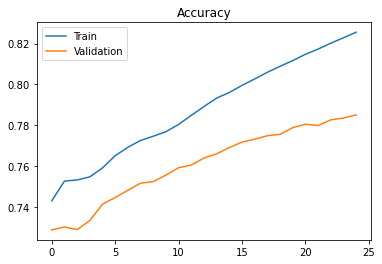

In [33]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy');

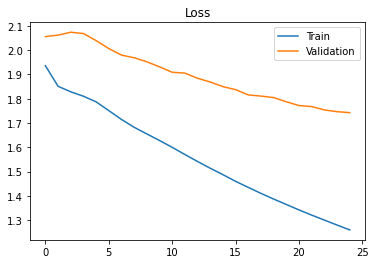

In [34]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title('Loss');

In [35]:
from tensorflow.keras.models import Model, load_model

training_model = load_model('training_model_v2.h5')

encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [36]:
def string_to_matrix(user_input):
    '''This function takes in a string and outputs the corresponding matrix'''
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    for timestep, token in enumerate(tokens):
        if token in input_features_dict:
            user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix

In [37]:
training_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4428)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 7675)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 4797440     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  8122368     input_2[0][0]                    
                                                                 lstm[0][1]                   

In [38]:
def decode_sequence(test_input):
    '''This function takes in a sentence and returns the decoded sentence'''
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(string_to_matrix(test_input))

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first token of target sequence with the start token.
    target_seq[0, 0, target_features_dict['<START>']] = 1.

    # Sampling loop for a batch of sequences
    decoded_sentence = ''

    stop_condition = False
    while not stop_condition:
        # Run the decoder model to get possible output tokens (with probabilities) & states
        output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

        # Choose token with highest probability and append it to decoded sentence
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_features_dict[sampled_token_index]
        decoded_sentence += " " + sampled_token

        # Exit condition: either hit max length or find stop token.
        if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [hidden_state, cell_state]

    return decoded_sentence

In [39]:
# Example decoded sentence
decode_sequence('how are you')

' qué están está <END>'

In [40]:
# Example decoded sentence
decode_sequence('it is hot today')

' hoy es <END>'

In [42]:
# Example decoded sentence
decode_sequence('i am Shashank')

' estoy estoy <END>'

In [45]:
class ChatBot:
    '''
    Utilizing the neural network architecture, this class is to translates English to Spanish. 
    '''
    negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")


    exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop", 'end')

    def start_chat(self):
        user_response = input("Hello - what do you want to translate to Spanish?\n")
    
        if user_response.lower() in self.negative_responses:
            print("Ok, have a great day!")
            return
    
        #user_response = input('Great!')
    
        self.chat(user_response)
  
    def chat(self, reply):
        while not self.make_exit(reply):
            reply = input(self.generate_response(reply))
    

    def string_to_matrix(self, user_input):
        tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
        user_input_matrix = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
        for timestep, token in enumerate(tokens):
            if token in input_features_dict:
                user_input_matrix[0, timestep, input_features_dict[token]] = 1.

        return user_input_matrix

    def generate_response(self, user_input):
        input_matrix = self.string_to_matrix(user_input)
        states_value = encoder_model.predict(input_matrix)
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, target_features_dict['<START>']] = 1.0
    
        chatbot_response = ''

        stop_condition = False

        while not stop_condition:

            output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_token = reverse_target_features_dict[sampled_token_index]
            chatbot_response += " " + sampled_token

            if (sampled_token == '<END>' or len(chatbot_response) > max_decoder_seq_length):
                stop_condition = True

                target_seq = np.zeros((1, 1, num_decoder_tokens))
                target_seq[0, 0, sampled_token_index] = 1.

            if '<END>' in chatbot_response:
                chatbot_response = chatbot_response.replace('<END>', '')

            punctuations = [' ?', ' .', ' !', ' ,']            
            for punctuation in punctuations:
                if punctuation in chatbot_response:
                    chatbot_response = chatbot_response.replace(punctuation, punctuation[-1])


            states_value = [hidden_state, cell_state]

        return chatbot_response
  
    def make_exit(self, reply):
        for exit_command in self.exit_commands:
            if exit_command in reply:
                print("Ok, have a great day!")
                return True

In [ ]:
# Chat!
chat = ChatBot()
chat.start_chat()

Hello - what do you want translates to Spanish?
 it is hot today
Great! it is not nice
